In [13]:
# 文件名: 2_分组与时点优化_求解_最终版.py

import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from scipy.stats import norm
from tqdm import tqdm

# --- 核心计算函数 ---
def calculate_prob_fail(t_weeks, bmi, age):
    """【最终修正版】计算失败概率函数"""
    intercept, coef_t_weeks, coef_bmi, coef_age = 0.102, 0.003, -0.001, -0.001
    var_total, S_calibration = 0.0013, 0.03; std_total = np.sqrt(var_total)
    mu_original = intercept + coef_t_weeks * t_weeks + coef_bmi * bmi + coef_age * age
    mu_calibrated = mu_original - S_calibration
    z_score = (0.04 - mu_calibrated) / std_total; return norm.cdf(z_score)

def calculate_R_late(t_days):
    """计算过晚检测风险 R_late(t)"""
    if 70 <= t_days <= 84: return 0.0
    elif 84 < t_days <= 189: return (6 / 105) * (t_days - 84)
    elif 189 < t_days <= 210: return 0.0607 * np.exp(0.0243 * t_days)
    else: return np.nan

def calculate_expected_risk(t_days, bmi, age, w_late=0.1):
    """【最终修正版-返回分解项】计算总期望风险 E(R|t)"""
    C_redraw = 0.2
    t_weeks = t_days / 7.0
    r_late_current = calculate_R_late(t_days)
    r_late_future = calculate_R_late(t_days + 14)
    if np.isnan(r_late_current) or np.isnan(r_late_future): return (np.inf, np.inf, np.inf)
    
    opportunity_cost = r_late_future - r_late_current
    prob_fail = calculate_prob_fail(t_weeks, bmi, age)
    
    risk_from_lateness = w_late * r_late_current
    penalty_from_failure = w_late * opportunity_cost + C_redraw
    risk_from_failure_prob = prob_fail * penalty_from_failure
    
    total_risk = risk_from_lateness + risk_from_failure_prob
    return (total_risk, risk_from_lateness, risk_from_failure_prob)

def format_weeks_days(total_days):
    """将天数格式化为'周+天'"""
    weeks = int(total_days // 7); days = int(np.round(total_days % 7)); return f"{weeks}周+{days}天"

# --- 主程序入口 ---
if __name__ == '__main__':
    W_LATE_FINAL = 0.02 # <-- 我们在这里设定最终选定的w_late值
    print(f"--- 最终模型参数设定: w_late = {W_LATE_FINAL} ---")

    print("--- 步骤一：数据加载与准备 ---")
    DATA_PATH = '../../Data/0/男胎_预处理后数据.csv'
    RESULT_DIR = 'Result'; os.makedirs(RESULT_DIR, exist_ok=True)
    df_male = pd.read_csv(DATA_PATH)
    outlier_cols = ['Y染色体浓度', '孕妇BMI', '年龄']
    for col in outlier_cols:
        Q1, Q3 = df_male[col].quantile(0.25), df_male[col].quantile(0.75); IQR = Q3 - Q1
        lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        df_male = df_male[(df_male[col] >= lower_bound) & (df_male[col] <= upper_bound)]
    df_model_data = df_male[['孕妇代码', '孕妇BMI', '年龄']].copy().drop_duplicates(subset=['孕妇代码']).reset_index(drop=True)
    print(f"最终用于优化分析的孕妇样本数: {len(df_model_data)}")

    print("\n--- 步骤二：寻找最优分组数 K ---")
    K_RANGE, T_GRID_DAYS = range(2, 6), range(70, 197) # 减少K的范围以加快速度
    results_by_k = {}
    for k in tqdm(K_RANGE, desc="处理不同K值"):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(df_model_data[['孕妇BMI']])
        df_model_data['group'] = kmeans.labels_
        group_risks = []
        for i in range(k):
            group_data = df_model_data[df_model_data['group'] == i]
            min_avg_risk = min([group_data.apply(lambda r: calculate_expected_risk(t, r['孕妇BMI'], r['年龄'], w_late=W_LATE_FINAL)[0], axis=1).mean() for t in T_GRID_DAYS])
            group_risks.append({'n_samples': len(group_data), 'min_avg_risk': min_avg_risk})
        results_by_k[k] = sum((d['n_samples'] / len(df_model_data)) * d['min_avg_risk'] for d in group_risks)
    
    N_samples = len(df_model_data)
    bic_scores = {k: N_samples * np.log(risk) + np.log(N_samples) * k for k, risk in results_by_k.items()}
    optimal_k = min(bic_scores, key=bic_scores.get)
    print(f"\n根据BIC准则，最优分组数确定为 K = {optimal_k}")

    print(f"\n--- 步骤三：使用 K={optimal_k} 生成最终方案 ---")
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(df_model_data[['孕妇BMI']])
    df_model_data['group'] = kmeans.labels_
    group_bmi_medians = df_model_data.groupby('group')['孕妇BMI'].median().sort_values().index
    group_map = {old: new for new, old in enumerate(group_bmi_medians)}
    df_model_data['group'] = df_model_data['group'].map(group_map)
    
    final_results, plot_data = [], {'risk_curves': {}, 'optimal_points': []}
    for i in range(optimal_k):
        group_data = df_model_data[df_model_data['group'] == i]
        
        # 【BUG修正】对每个时间点，计算风险向量，然后求均值
        risk_details_df = pd.DataFrame([
            group_data.apply(lambda r: calculate_expected_risk(t, r['孕妇BMI'], r['年龄'], w_late=W_LATE_FINAL), axis=1).apply(pd.Series).mean()
            for t in T_GRID_DAYS
        ])
        risk_details_df.columns = ['total', 'late', 'fail']
        risk_details_df['t'] = T_GRID_DAYS

        optimal_point = risk_details_df.loc[risk_details_df['total'].idxmin()]
        optimal_t = int(optimal_point['t']); min_avg_risk = optimal_point['total']
        
        bmi_min, bmi_max = group_data['孕妇BMI'].min(), group_data['孕妇BMI'].max()
        final_results.append({'分组序号': f"分组 {i+1}", 'BMI范围': f"{bmi_min:.2f} - {bmi_max:.2f}", '样本数': len(group_data),
                              '最佳NIPT时点(天)': optimal_t, '最佳NIPT时点(周)': format_weeks_days(optimal_t), '最小平均风险': min_avg_risk})
        
        plot_data['risk_curves'][f"分组 {i+1}"] = risk_details_df
        plot_data['optimal_points'].append({'group_name': f"分组 {i+1} (BMI: {bmi_min:.1f}-{bmi_max:.1f})", 'optimal_t_days': optimal_t})

    df_final_results = pd.DataFrame(final_results)
    print("\n--- 问题二：最终NIPT时点推荐方案 ---"); print(df_final_results.to_string(index=False))
    table_path = os.path.join(RESULT_DIR, '问题二_最终NIPT时点推荐方案.csv')
    df_final_results.to_csv(table_path, index=False, encoding='utf-8-sig')
    print(f"\n结果表格已保存至: {table_path}\n求解部分已完成，绘图所需数据已生成。")

--- 最终模型参数设定: w_late = 0.02 ---
--- 步骤一：数据加载与准备 ---
最终用于优化分析的孕妇样本数: 258

--- 步骤二：寻找最优分组数 K ---


处理不同K值:   0%|          | 0/4 [00:00<?, ?it/s]d:\Conda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
处理不同K值:  25%|██▌       | 1/4 [00:02<00:06,  2.17s/it]d:\Conda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
处理不同K值:  50%|█████     | 2/4 [00:04<00:04,  2.22s/it]d:\Conda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
处理不同K值:  75%|███████▌  | 3/4 [00:


根据BIC准则，最优分组数确定为 K = 2

--- 步骤三：使用 K=2 生成最终方案 ---

--- 问题二：最终NIPT时点推荐方案 ---
分组序号         BMI范围  样本数  最佳NIPT时点(天) 最佳NIPT时点(周)   最小平均风险
分组 1 26.62 - 32.14  156           84      12周+0天 0.086326
分组 2 32.24 - 39.30  102           84      12周+0天 0.096468

结果表格已保存至: Result\问题二_最终NIPT时点推荐方案.csv
求解部分已完成，绘图所需数据已生成。



--- 开始执行可视化 ---

结果图表已保存至: Result\问题二_BMI分组风险曲线分解图_K=2.png


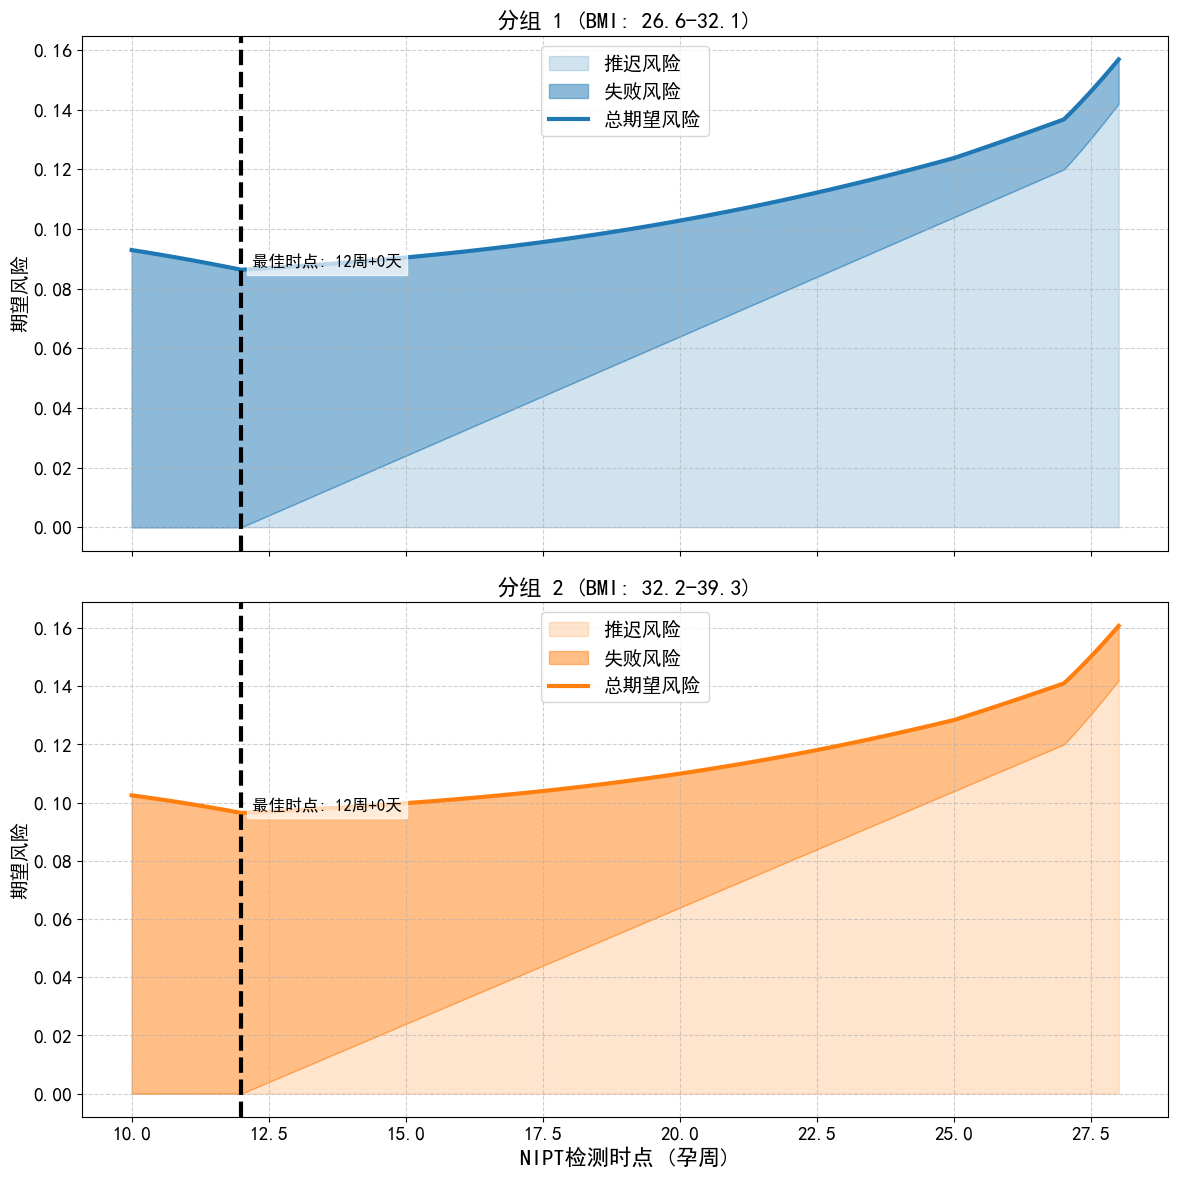

In [14]:
# 文件名: 2_分组与时点优化_可视化_最终版.py

import matplotlib.pyplot as plt
import matplotlib as mpl

# --- 图表全局设置 ---
mpl.rcParams['font.sans-serif'] = ['SimHei']; mpl.rcParams['font.serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False; mpl.rcParams['font.size'] = 14; mpl.rcParams['lines.linewidth'] = 3

def format_weeks_days(total_days): # 在可视化部分也需要这个函数
    weeks = int(total_days // 7); days = int(np.round(total_days % 7)); return f"{weeks}周+{days}天"

# --- 绘图函数 ---
def plot_risk_curves(plot_data, optimal_k, result_dir):
    """使用计算好的数据进行绘图，并分解风险来源"""
    fig, axes = plt.subplots(optimal_k, 1, figsize=(12, 6 * optimal_k), sharex=True, squeeze=False)
    axes = axes.flatten() # 保证axes可迭代
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    for i, ax in enumerate(axes):
        if i >= optimal_k: ax.set_visible(False); continue # 隐藏多余的子图
        group_name = f"分组 {i+1}"
        df_curve = plot_data['risk_curves'][group_name]
        point = plot_data['optimal_points'][i]
        
        ax.fill_between(df_curve['t']/7, 0, df_curve['late'], color=colors[i % len(colors)], alpha=0.2, label='推迟风险')
        ax.fill_between(df_curve['t']/7, df_curve['late'], df_curve['total'], color=colors[i % len(colors)], alpha=0.5, label='失败风险')
        ax.plot(df_curve['t']/7, df_curve['total'], color=colors[i % len(colors)], label='总期望风险')
        
        optimal_t_weeks = point['optimal_t_days'] / 7
        time_label = format_weeks_days(point['optimal_t_days'])
        min_risk_val = df_curve['total'].min()
        ax.axvline(x=optimal_t_weeks, linestyle='--', color='black')
        ax.text(optimal_t_weeks + 0.2, min_risk_val, f'最佳时点: {time_label}', 
                 color='black', backgroundcolor=(1,1,1,0.7), fontsize=12, va='bottom')

        ax.set_title(point['group_name'], fontsize=16)
        ax.set_ylabel('期望风险', fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend()

    axes[-1].set_xlabel('NIPT检测时点 (孕周)', fontsize=16)
    plt.tight_layout()
    
    figure_path = os.path.join(RESULT_DIR, f'问题二_BMI分组风险曲线分解图_K={optimal_k}.png')
    plt.savefig(figure_path, dpi=300, bbox_inches='tight')
    print(f"\n结果图表已保存至: {figure_path}")
    plt.show()

# --- 主程序入口 ---
if __name__ == '__main__' and 'plot_data' in locals():
    print("\n--- 开始执行可视化 ---")
    plot_risk_curves(plot_data, optimal_k, RESULT_DIR)
else:
    print("\n请先完整运行“求解代码”部分以生成绘图所需的数据。")

--- 步骤一：数据加载与达标时间计算 ---
最终用于优化分析的孕妇样本数: 258

--- 步骤二、三、四：执行分组与优化 ---


处理不同K值:   0%|          | 0/6 [00:00<?, ?it/s]d:\Conda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
处理不同K值:  17%|█▋        | 1/6 [00:00<00:01,  2.60it/s]d:\Conda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
处理不同K值:  33%|███▎      | 2/6 [00:00<00:01,  2.43it/s]d:\Conda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
处理不同K值:  50%|█████     | 3/6 [00:


最优分组数确定为 K = 2

--- 使用 K=2 生成最终方案 ---

--- 最终NIPT时点推荐方案 ---
分组序号         BMI范围  样本数  最佳NIPT时点(天) 最佳NIPT时点(周)  最小累积风险
分组 1 26.62 - 32.14  156           70      10周+0天     0.0
分组 2 32.24 - 39.30  102           70      10周+0天     0.0

结果表格已保存至: Result\问题二_确定性模型推荐方案.csv


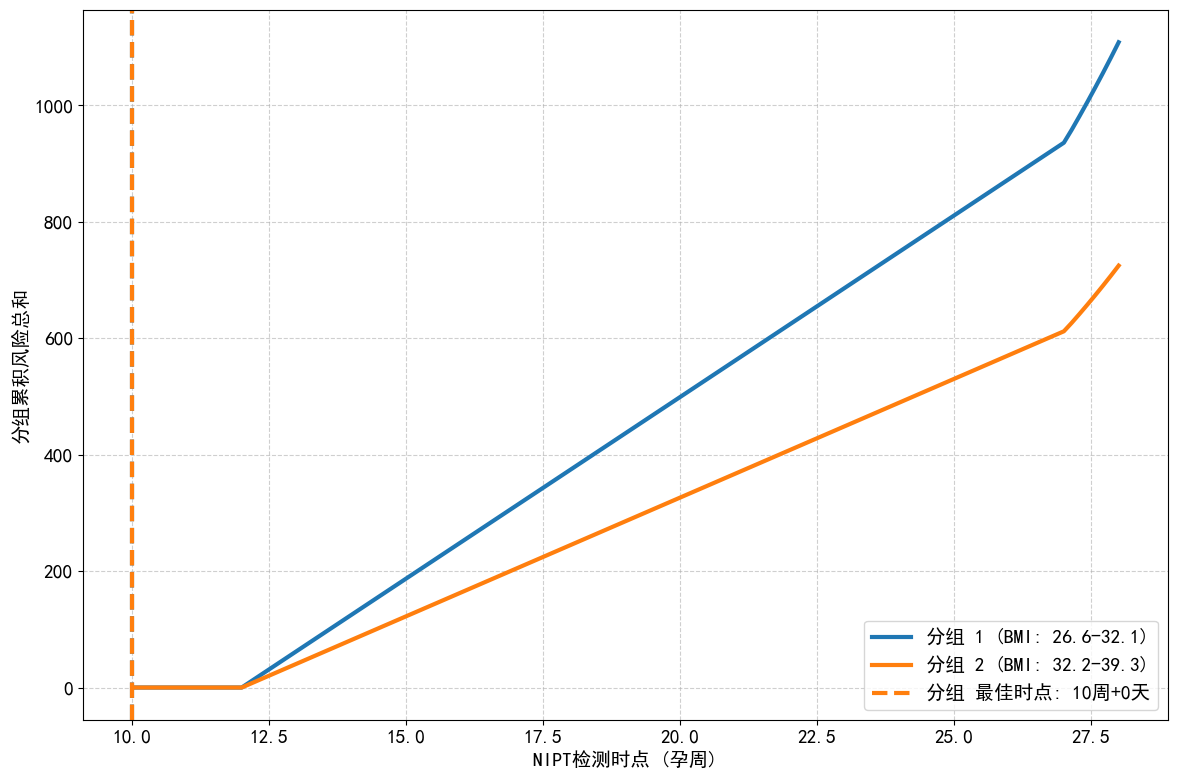

结果图表已保存至: Result\问题二_确定性模型风险曲线_K=2.png


In [15]:
# 文件名: 3_确定性模型求解.py

import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- 全局设置 ---
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.size'] = 14

# --- 核心计算函数 (遵照您的方案) ---

def calculate_t_achieve(bmi, age):
    """
    (第一步) 基于问题一模型，反解出确定的达标孕周 t_达标 (单位：周)
    公式: 0.04 = 0.102 + 0.003 * t_weeks - 0.001 * BMI - 0.001 * Age
    """
    # 整理公式: 0.003 * t_weeks = 0.04 - 0.102 + 0.001 * BMI + 0.001 * Age
    t_weeks = (0.001 * (bmi + age) - 0.062) / 0.003
    return t_weeks

def calculate_R_late(t_days):
    """(第三步) 定义过晚检测风险函数 R_late(t)"""
    if 70 <= t_days <= 84: return 0.0
    elif 84 < t_days <= 189: return (6 / 105) * (t_days - 84)
    elif 189 < t_days <= 210: return 0.0607 * np.exp(0.0243 * t_days)
    else: return np.nan # 使用 np.nan 便于处理超出定义域的情况

def calculate_individual_risk(t_days, t_achieve_days):
    """(第三步) 定义基于0/1指示函数的个体风险"""
    DELTA_T = 14  # 延迟14天

    # 计算指示函数 I_j(t_i)
    # 如果达标时间晚于检测时间，则失败 (I=1)
    indicator = 1 if t_achieve_days > t_days else 0
    
    # 计算风险组件
    r_late_current = calculate_R_late(t_days)
    
    # 检查定义域
    if np.isnan(r_late_current): return np.inf

    # 根据您的公式计算风险
    if indicator == 0: # 成功
        return r_late_current
    else: # 失败
        r_late_future = calculate_R_late(t_days + DELTA_T)
        if np.isnan(r_late_future): return np.inf
        opportunity_cost = r_late_future - r_late_current
        # 【注意】这里严格遵照了您的公式：Risk = (1-I)*R_late + I*[Opportunity_Cost]
        # 而不是 Risk = R_late + I*[Opportunity_Cost]
        return opportunity_cost
        
def format_weeks_days(total_days):
    """将天数格式化为'周+天'"""
    weeks = int(total_days // 7); days = int(np.round(total_days % 7)); return f"{weeks}周+{days}天"

# --- 主程序入口 ---
if __name__ == '__main__':
    print("--- 步骤一：数据加载与达标时间计算 ---")
    DATA_PATH = '../../Data/0/男胎_预处理后数据.csv'
    RESULT_DIR = 'Result'; os.makedirs(RESULT_DIR, exist_ok=True)
    df_male = pd.read_csv(DATA_PATH)

    outlier_cols = ['Y染色体浓度', '孕妇BMI', '年龄']
    for col in outlier_cols:
        Q1, Q3 = df_male[col].quantile(0.25), df_male[col].quantile(0.75); IQR = Q3 - Q1
        lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        df_male = df_male[(df_male[col] >= lower_bound) & (df_male[col] <= upper_bound)]
    
    df_model_data = df_male[['孕妇代码', '孕妇BMI', '年龄']].copy().drop_duplicates(subset=['孕妇代码']).reset_index(drop=True)
    
    # 计算每个个体的 t_达标
    df_model_data['t_achieve_weeks'] = df_model_data.apply(lambda row: calculate_t_achieve(row['孕妇BMI'], row['年龄']), axis=1)
    df_model_data['t_achieve_days'] = df_model_data['t_achieve_weeks'] * 7
    # 处理异常值：如果计算出的达标时间<0，说明很早就达标，视为0
    df_model_data.loc[df_model_data['t_achieve_days'] < 0, 't_achieve_days'] = 0
    
    print(f"最终用于优化分析的孕妇样本数: {len(df_model_data)}")

    print("\n--- 步骤二、三、四：执行分组与优化 ---")
    K_RANGE, T_GRID_DAYS = range(2, 8), range(70, 197)
    results_by_k = {}

    for k in tqdm(K_RANGE, desc="处理不同K值"):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(df_model_data[['孕妇BMI']])
        df_model_data['group'] = kmeans.labels_
        
        total_risk_for_k = 0
        for i in range(k):
            group_data = df_model_data[df_model_data['group'] == i]
            min_group_risk = np.inf
            for t_days in T_GRID_DAYS:
                # 计算该组在该天的累积风险总和
                group_risk_sum = group_data.apply(lambda row: calculate_individual_risk(t_days, row['t_achieve_days']), axis=1).sum()
                if group_risk_sum < min_group_risk:
                    min_group_risk = group_risk_sum
            total_risk_for_k += min_group_risk
        results_by_k[k] = total_risk_for_k

    optimal_k = min(results_by_k, key=results_by_k.get)
    print(f"\n最优分组数确定为 K = {optimal_k}")

    print(f"\n--- 使用 K={optimal_k} 生成最终方案 ---")
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(df_model_data[['孕妇BMI']])
    df_model_data['group'] = kmeans.labels_
    group_bmi_medians = df_model_data.groupby('group')['孕妇BMI'].median().sort_values().index
    group_map = {old: new for new, old in enumerate(group_bmi_medians)}
    df_model_data['group'] = df_model_data['group'].map(group_map)
    
    final_results, plot_data = [], {'risk_curves': {}, 'optimal_points': []}

    for i in range(optimal_k):
        group_data = df_model_data[df_model_data['group'] == i]
        risk_curve = [group_data.apply(lambda row: calculate_individual_risk(t, row['t_achieve_days']), axis=1).sum() for t in T_GRID_DAYS]
        
        min_risk_val = min(risk_curve)
        optimal_t = T_GRID_DAYS[np.argmin(risk_curve)]
        
        bmi_min, bmi_max = group_data['孕妇BMI'].min(), group_data['孕妇BMI'].max()
        final_results.append({
            '分组序号': f"分组 {i+1}", 'BMI范围': f"{bmi_min:.2f} - {bmi_max:.2f}",
            '样本数': len(group_data), '最佳NIPT时点(天)': optimal_t,
            '最佳NIPT时点(周)': format_weeks_days(optimal_t), '最小累积风险': min_risk_val
        })
        plot_data['risk_curves'][f"分组 {i+1}"] = risk_curve
        plot_data['optimal_points'].append({'group_name': f"分组 {i+1} (BMI: {bmi_min:.1f}-{bmi_max:.1f})", 'optimal_t': optimal_t})
    
    df_final_results = pd.DataFrame(final_results)
    print("\n--- 最终NIPT时点推荐方案 ---"); print(df_final_results.to_string(index=False))
    table_path = os.path.join(RESULT_DIR, '问题二_确定性模型推荐方案.csv')
    df_final_results.to_csv(table_path, index=False, encoding='utf-8-sig')
    print(f"\n结果表格已保存至: {table_path}")

    # --- 可视化 ---
    plt.figure(figsize=(12, 8))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    for i, point in enumerate(plot_data['optimal_points']):
        group_name, optimal_t = point['group_name'], point['optimal_t']
        risk_curve = plot_data['risk_curves'][group_name.split(" ")[0] + " " + group_name.split(" ")[1]]
        
        plt.plot([t/7 for t in T_GRID_DAYS], risk_curve, label=group_name, color=colors[i % len(colors)])
        plt.axvline(x=optimal_t/7, linestyle='--', color=colors[i % len(colors)], 
                    label=f'{group_name.split(" ")[0]} 最佳时点: {format_weeks_days(optimal_t)}')

    plt.xlabel('NIPT检测时点 (孕周)'); plt.ylabel('分组累积风险总和'); plt.grid(True, linestyle='--', alpha=0.6)
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = {label: handle for handle, label in sorted(zip(handles, labels), key=lambda x: x[1])}
    plt.legend(unique_labels.values(), unique_labels.keys()); plt.tight_layout()
    figure_path = os.path.join(RESULT_DIR, f'问题二_确定性模型风险曲线_K={optimal_k}.png')
    plt.savefig(figure_path, dpi=300); plt.show()
    print(f"结果图表已保存至: {figure_path}")